<a href="https://www.kaggle.com/code/tharunkumar1818/mini2?scriptVersionId=205209738" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# install datasets
!pip install datasets

In [2]:
from datasets import load_dataset

big_multilabel_dataset = load_dataset(path="mwritescode/slither-audited-smart-contracts", name="big-multilabel")

slither-audited-smart-contracts.py:   0%|          | 0.00/8.00k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.12k [00:00<?, ?B/s]

The repository for mwritescode/slither-audited-smart-contracts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mwritescode/slither-audited-smart-contracts.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


contracts0.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

contracts1.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

contracts2.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

contracts3.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

contracts4.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

contracts5.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

contracts6.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

contracts7.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

contracts8.parquet:   0%|          | 0.00/4.04M [00:00<?, ?B/s]

data/label_mappings.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

data/big-splits.csv:   0%|          | 0.00/4.97M [00:00<?, ?B/s]

data/small-splits.csv:   0%|          | 0.00/659k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/79641 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10861 [00:00<?, ? examples/s]

In [3]:
def clean_data(dataset):
  cleaned_data = []
  for data in dataset:
    # clean the bytecode and the 4 output that represents if the contract is safe
    if (len(data['bytecode']) > 4):
      if (4 in data['slither']):
       data['slither'].remove(4)
      new_slither_output = []
      for output in data['slither']:
         if (output > 4):
           new_slither_output.append(output - 1)
         else:
           new_slither_output.append(output)
      data['slither']=new_slither_output
      cleaned_data.append(data)
  return cleaned_data

cleaned_training_data = clean_data(big_multilabel_dataset["train"])
cleaned_validation_data = clean_data(big_multilabel_dataset["validation"])
cleaned_test_data = clean_data(big_multilabel_dataset["test"])

len(cleaned_training_data), len(cleaned_validation_data), len(cleaned_test_data)

(79414, 10831, 15921)

In [4]:
def split_text_into_chars(text, length):
  return " ".join([text[i:i+length] for i in range(0, len(text), length)])
train_bytecode = [split_text_into_chars(data['bytecode'][2:],1) for data in cleaned_training_data]
test_bytecode = [split_text_into_chars(data['bytecode'][2:],1) for data in cleaned_test_data]
val_bytecode = [split_text_into_chars(data['bytecode'][2:],1) for data in  cleaned_validation_data]

In [5]:
import numpy as np
bytecodes_length = [len(bytecode.split()) for bytecode in train_bytecode]
output_seq_len = int(np.percentile(bytecodes_length, 95))

# Find the maximu number of tokens that could represent the bytecode
import string
max_tokens = (len(string.hexdigits) - 6) ** 2

In [6]:
import numpy as np
training_slither = [data['slither'] for data in cleaned_training_data]
validation_slither = [data['slither'] for data in cleaned_validation_data]
test_slither = [data['slither'] for data in cleaned_test_data]

num_classes = len(np.unique(np.concatenate(training_slither)))

In [7]:
# Convert labels to binary vectors
import numpy as np

def labels_to_binary(y, num_labels):
    """
    Converts the labels into binary format
    depending on the total number of labels,
    for example: y = [1,4], num_labels = 5, y_binary = [0,1,0,0,1,0]
    """
    y_binary = np.zeros((len(y), num_labels), dtype=float)
    for i, label_indices in enumerate(y):
        y_binary[i, label_indices] = 1
    return y_binary

train_labels_binary = labels_to_binary(training_slither, num_classes)
valid_labels_binary = labels_to_binary(validation_slither, num_classes)
test_labels_binary = labels_to_binary(test_slither, num_classes)


In [8]:
def transform_labels_to_dict(labels_binary):
    labels_dict = {}
    for index in range(num_classes):
        labels_dict[f'{index}'] = []

    for labels in labels_binary:
        for index, label in enumerate(labels):
            labels_dict[f'{index}'].append(label)
    
    return labels_dict  # Correctly indented return statement

validation_dict = transform_labels_to_dict(valid_labels_binary)
train_dict = transform_labels_to_dict(train_labels_binary)
test_dict = transform_labels_to_dict(test_labels_binary)


In [9]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_bytecode, train_dict)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((val_bytecode, validation_dict)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_bytecode, test_dict)).batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
max_tokens=100
output_seq_len = 21041
text_vectorizer = tf.keras.layers.TextVectorization(
    split="whitespace",
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len
)
text_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(train_bytecode).batch(32).prefetch(tf.data.AUTOTUNE))

In [11]:
bytecode_vocab = text_vectorizer.get_vocabulary()
print(f"Number of different characters in vocab: {len(bytecode_vocab)}")
print(f"5 most common characters: {bytecode_vocab[:5]}")
print(f"5 least common characters: {bytecode_vocab[-5:]}")

Number of different characters in vocab: 18
5 most common characters: ['', '[UNK]', '0', 'f', '6']
5 least common characters: ['7', 'd', 'a', 'e', 'c']


In [12]:
embedding_layer = tf.keras.layers.Embedding(
input_dim=len(bytecode_vocab),
input_length=output_seq_len,
output_dim=128,
mask_zero=False, # Conv layers do not support masking
name="embedding_layer"
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
from tensorflow.keras import layers
# Create the input layer
inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

# Create the bytecode tokens
x = text_vectorizer(inputs)

# Create the embedding layer
x = embedding_layer(x)

# Create the first block
x = layers.Conv1D(filters=4, kernel_size=3, strides=1, padding='valid', name="conv_layer_2")(x)
x = layers.Conv1D(filters=4, kernel_size=3, strides=1, padding='valid', name="conv_layer_3")(x)
x = layers.MaxPooling1D()(x)

# Create the second block
x = layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='valid', name="conv_layer_4")(x)
x = layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='valid', name="conv_layer_5")(x)
x = layers.MaxPooling1D()(x)

# Create the third block
x = layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='valid', name="conv_layer_6")(x)
x = layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='valid', name="conv_layer_7")(x)
x = layers.MaxPooling1D()(x)

# Add the global max layer
x = layers.GlobalMaxPooling1D()(x)

# Add a dense layer
x = layers.Dense(32, activation="relu")(x)

# Create the output layers
outputs = []
for index in range(num_classes):
    output = layers.Dense(1, activation="sigmoid", name=f'{index}')(x)
    outputs.append(output)

# Create the model
model_1 = tf.keras.Model(inputs, outputs, name="model_1")


In [14]:
losses={}
metrics={}
for index in range(num_classes):
  losses[f'{index}'] = "binary_crossentropy"
  metrics[f'{index}'] = ['accuracy']
model_1.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03), metrics=metrics)

In [15]:
history_1 = model_1.fit(train_dataset,
                        epochs=35,
                        validation_data=validation_dataset,
                        callbacks=[
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                        patience=5),
                                   tf.keras.callbacks.ModelCheckpoint(filepath=f"model_experiments/model_1.keras",  # Add .keras extension
                                                                      monitor='val_loss',
                                                                      verbose=0,
                                                                      save_best_only=True)
                                  ])


Epoch 1/35
2482/2482 ━━━━━━━━━━━━━━━━━━━━ 361s 142ms/step - 0_accuracy: 0.8516 - 1_accuracy: 0.8274 - 2_accuracy: 0.7358 - 3_accuracy: 0.7790 - 4_accuracy: 0.7324 - loss: 2.3437 - val_0_accuracy: 0.8415 - val_1_accuracy: 0.8360 - val_2_accuracy: 0.7712 - val_3_accuracy: 0.8334 - val_4_accuracy: 0.7731 - val_loss: 2.0990 - learning_rate: 0.0010
Epoch 2/35
2482/2482 ━━━━━━━━━━━━━━━━━━━━ 352s 142ms/step - 0_accuracy: 0.8668 - 1_accuracy: 0.8479 - 2_accuracy: 0.7829 - 3_accuracy: 0.8502 - 4_accuracy: 0.8186 - loss: 1.8936 - val_0_accuracy: 0.8569 - val_1_accuracy: 0.8506 - val_2_accuracy: 0.7789 - val_3_accuracy: 0.8461 - val_4_accuracy: 0.8085 - val_loss: 1.9390 - learning_rate: 0.0010
Epoch 3/35
2482/2482 ━━━━━━━━━━━━━━━━━━━━ 353s 142ms/step - 0_accuracy: 0.8742 - 1_accuracy: 0.8570 - 2_accuracy: 0.7949 - 3_accuracy: 0.8589 - 4_accuracy: 0.8273 - loss: 1.7962 - val_0_accuracy: 0.8652 - val_1_accuracy: 0.8510 - val_2_accuracy: 0.7908 - val_3_accuracy: 0.8466 - val_4_accuracy: 0.8181 - val

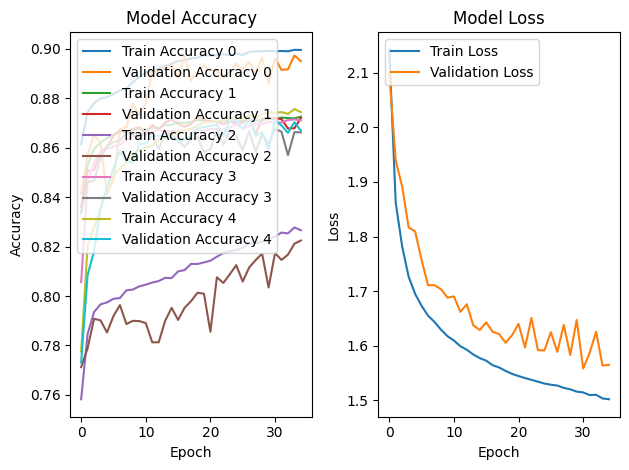

In [22]:
import matplotlib.pyplot as plt

# Create a subplot for accuracy
plt.subplot(1, 2, 1)

# Loop through the number of classes to plot each accuracy
for index in range(num_classes):
    plt.plot(history_1.history[f'{index}_accuracy'], label=f'Train Accuracy {index}')
    plt.plot(history_1.history[f'val_{index}_accuracy'], label=f'Validation Accuracy {index}')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Create a subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


In [23]:
def convert_preds_probs_to_preds(preds_probs):
    preds = []  # List to hold the final predictions
    for pred_prob in preds_probs:
        # Convert probabilities to binary predictions
        converted_pred_prob = [1 if value[0] >= 0.5 else 0 for value in pred_prob]
        preds.append(converted_pred_prob)
    
    preds_dict = {}  # Dictionary to hold predictions for each output
    for index in range(len(preds)):
        preds_dict[f'{index}'] = preds[index]  # Assign predictions to respective keys
    
    return preds_dict


In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
    y_true: true labels in the form of a 1D array
    y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

def combine_results(y_true, y_pred):
    results = {}
    for index in range(num_classes):
        results[f'{index}'] = calculate_results(y_true=test_dict[f'{index}'], y_pred=model_1_preds[f'{index}'])
    return results


In [25]:
# Step 1: Generate predictions on the test dataset
model_1_preds_probs = model_1.predict(test_dataset)

# Step 2: Convert probabilities to binary predictions
model_1_preds = convert_preds_probs_to_preds(model_1_preds_probs)

# Step 3: Combine results to calculate metrics
results = combine_results(y_true=test_dict, y_pred=model_1_preds)

# Step 4: Create a DataFrame from the results for visualization
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step
                   0          1          2          3          4
accuracy   89.755669  87.186735  82.274983  86.734502  86.740783
precision   0.888100   0.867973   0.814044   0.871752   0.868518
recall      0.897557   0.871867   0.822750   0.867345   0.867408
f1          0.886441   0.845968   0.812482   0.859575   0.866817


498/498 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step


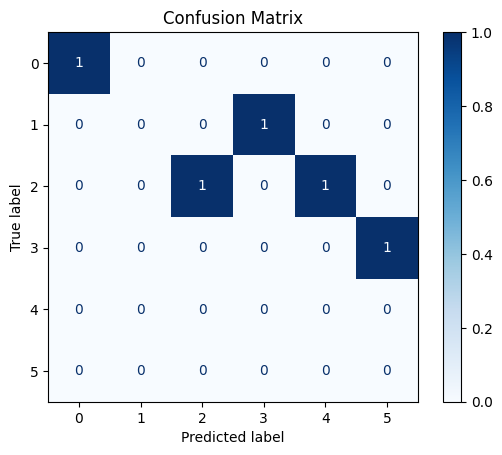

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set using the correct model
# Make sure to predict using the appropriate dataset
# For a model with multiple outputs, you may need to use the test dataset accordingly
model_1_preds_probs = model_1.predict(test_dataset)  # Use your trained model here

# Convert probabilities to binary class labels
model_1_preds = convert_preds_probs_to_preds(model_1_preds_probs)

# Convert predictions to a format suitable for confusion matrix calculation
# Assuming test_dict contains the true labels for each class
y_pred_classes = [np.argmax(pred) for pred in model_1_preds.values()]  # Modify according to your structure
y_test_classes = [np.argmax(true) for true in test_dict.values()]  # Convert test_dict to class labels

# Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [28]:
# Save the model after training
model_1.save("/kaggle/working/model_1.h5")


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Input
import os

# Create and compile your model
model = Sequential()
model.add(Input(shape=(784,)))  # Use Input layer to specify the input shape
model.add(Dense(32, activation='relu'))  # First hidden layer
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Save the model
model.save('my_model.h5')

# Check if the file exists
print(os.listdir('.'))  # Should show 'my_model.h5'


['model_experiments', 'model_1.h5', '.virtual_documents', 'my_model.h5']
